# Data

## Connect to data on Google Drive





In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

In [0]:
# Mount my google drive for saving models
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Load data

Data Links : \\
(1) StackExchangeSampleBody : https://drive.google.com/file/d/1zV5pKCoQ2uyIoS5v_IRFXq6Wl6F-W7Dr/view?usp=sharing \\
(2) StackExchangeSampleTopic : https://drive.google.com/file/d/144lRBGpzjrdEJo26tfaAwOYFwW9QNfHL/view?usp=sharing \\
(3) QuoraTopic : https://drive.google.com/file/d/1lm8eXR3ME2VYwSlB-2XmeuKH_6EVoj4j/view?usp=sharing 

In [0]:
import pickle
import numpy as np

def load_data(path):
  # Load data
  with open(path, 'rb') as f:
    data = pickle.load(f)
  return data

In [0]:
file_ids = {
    'train_data': '1-lil_uwz1aXsHBYKtDDsn2wWkCxQPFRH',
    'valid_data': '1-zCou-9eOBC4n9ebEKcsQdRTjy2U4cPG',
    'test_data': '1-oKdsv4Moxbs8CP3ngmAg_-zYjlKN52S'
    }

data = {}
for name, file_id in file_ids.items():
  downloaded = gdrive.CreateFile({'id': file_id})
  path = name + '.pkl'
  downloaded.GetContentFile(path)
  data[name] = load_data(path)

train_data, valid_data, test_data = data['train_data'], data['valid_data'], data['test_data']
print(train_data.shape, valid_data.shape, test_data.shape)

(323432,) (40429,) (40429,)


## Data exploration

Number of total question pairs : 323432
Number of related question pairs : 119515
Number of unrelated question pairs : 203917
{0: 323371, 1: 52, 2: 9, 3: 0, 4: 0, 5: 0}


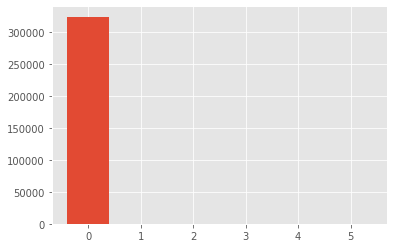

In [0]:
import matplotlib.pyplot as plt

def data_exploration(data):
  # Calculate number of total question pairs, related question pairs, and unrelated question pairs
  num_questions = 0
  num_related_questions = 0
  num_unrelated_questions = 0
  for d in data:
    num_questions += 1
    if(d['RelQuestionLabel'] == 0 or d['RelQuestionLabel'] == "Irrelevant"):
      num_unrelated_questions += 1
    else:
      num_related_questions += 1
  print('Number of total question pairs : %d' % num_questions)
  print('Number of related question pairs : %d' % num_related_questions)
  print('Number of unrelated question pairs : %d' % num_unrelated_questions)
  # Calculate question pair length distribution
  # Distribution initialization
  length_dist = {}
  for i in range(6):
    length_dist[i] = 0
  for d in data:
    question_pair_length = len(d['OrgQuestionText'].split()) + len(d['RelQuestionText'].split())
    idx = question_pair_length // 100
    if(idx < 5):
      length_dist[idx] += 1
    else:
      length_dist[5] += 1
  print(length_dist)
  plt.style.use('ggplot')
  plt.bar(x = list(range(6)), height = list(length_dist.values()))
  plt.show()

data_exploration(train_data)

# Baseline -- Word Matching


## Word matching functions

In [0]:
from typing import Callable, Set
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopset = set(stopwords.words('english'))
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

# Set up tokenizer
def text_preprocess(text: str, remove_punc = False, remove_stopwords = False, \
                    stemming = False, stopwords: Set[str] = stopset, \
                    stem_func: Callable[[str],str] = stemmer.stem) -> str:
    # Remove punctuations
    if remove_punc:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text with space
    tokens = text.split()

    # Convert tokens into lower cases
    tokens = map(lambda t: t.lower(), tokens)

    # Remove stopwords
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stopwords]
    
    # Perform stemming
    if stemming:
        tokens = [stem_func(t) for t in tokens]

    # Return preprocessed string
    return ' '.join(tokens)
    
# Set up word matching algorithm
def word_matching(OrgQuestion:str, RelQuestion:str):
  # Remove punctuations & stop words and apply stemming
  OrgQuestion = text_preprocess(text = OrgQuestion, remove_punc = True, remove_stopwords = True, stemming = True)
  RelQuestion = text_preprocess(text = RelQuestion, remove_punc = True, remove_stopwords = True, stemming = True)

  # Convert text into bag-of-word
  OrgQuestion_bow = set(OrgQuestion.split())
  RelQuestion_bow = set(RelQuestion.split())

  # Compute Jaccard Similarity between two bag-of-words
  Intersection_count = 0
  for word in OrgQuestion_bow:
    if(word in RelQuestion_bow):
      Intersection_count += 1
  Union_count = len(OrgQuestion_bow) + len(RelQuestion_bow) - Intersection_count
  if(Union_count > 0):
    JaccardSimilarity = Intersection_count / Union_count
  else:
    JaccardSimilarity = 0

  return JaccardSimilarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Threshold tuning

In [0]:
# Retrieve ground truth labels from train data
labels = []
for d in train_data:
  if(type(d['RelQuestionLabel']) is not int):
    if(d['RelQuestionLabel'] == "Irrelevant"):
      labels.append(0)
    else:
      labels.append(1)
  else:
    labels.append(d['RelQuestionLabel'])
    
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Threshold tuning with grid search
num_grid_search = 500
threshold_hist = []
f1_score_hist = []
precision_hist = []
recall_hist = []
best_threshold = None
best_f1_score = -np.inf

# Compute jaccard similarities for all question pairs once
y_preds = []
for d in train_data:
  y_pred = word_matching(d['OrgQuestionText'], d['RelQuestionText'])
  y_preds.append(y_pred)

# Use a threshold from grid
for threshold in np.linspace(1e-2, 1, num_grid_search): 
  # Train word matching algorithm
  pred_labels = []
  for y_pred in y_preds:
    if(y_pred >= threshold):
      pred_labels.append(1)
    else:
      pred_labels.append(0)
  # Compute F1-score, precision and recall with specified threshold
  current_f1_score = f1_score(labels, pred_labels)
  current_precision = precision_score(labels, pred_labels)
  current_recall = recall_score(labels, pred_labels)
  # Record current threshold, F1-score, precision, and recall
  threshold_hist.append(threshold)
  f1_score_hist.append(current_f1_score)
  precision_hist.append(current_precision)
  recall_hist.append(current_recall)
  # Report current threshold and F1-score
  print(threshold, current_f1_score)
  # Check if current threshold is the best one
  if(current_f1_score > best_f1_score):
    best_threshold = threshold
    best_f1_score = current_f1_score

# Report best threshold and F1-score    
print(best_threshold, best_f1_score)

0.01 0.5756623800874019
0.011983967935871743 0.5756623800874019
0.013967935871743487 0.5756623800874019
0.01595190380761523 0.5756623800874019
0.017935871743486972 0.5756637669148841
0.019919839679358717 0.5756637669148841
0.02190380761523046 0.5756679274374232
0.023887775551102206 0.5756679274374232
0.02587174348697395 0.5756762486629212
0.027855711422845694 0.5756915048678184
0.02983967935871744 0.5756970527791765
0.031823647294589176 0.5757234068184557
0.03380761523046092 0.5757650233723677
0.035791583166332665 0.5758343976673013
0.03777555110220441 0.5758704789079971
0.03975951903807615 0.5759315497710292
0.0417434869739479 0.5761287304886222
0.04372745490981964 0.5762384880835538
0.045711422845691387 0.5764191929060255
0.04769539078156313 0.5766403629431212
0.049679358717434875 0.5766417544867262
0.05166332665330661 0.5769160196237494
0.05364729458917836 0.5772909454173843
0.0556312625250501 0.5777417794970986
0.057615230460921846 0.5777515576907734
0.05959919839679359 0.578243688

## Baseline evaluation

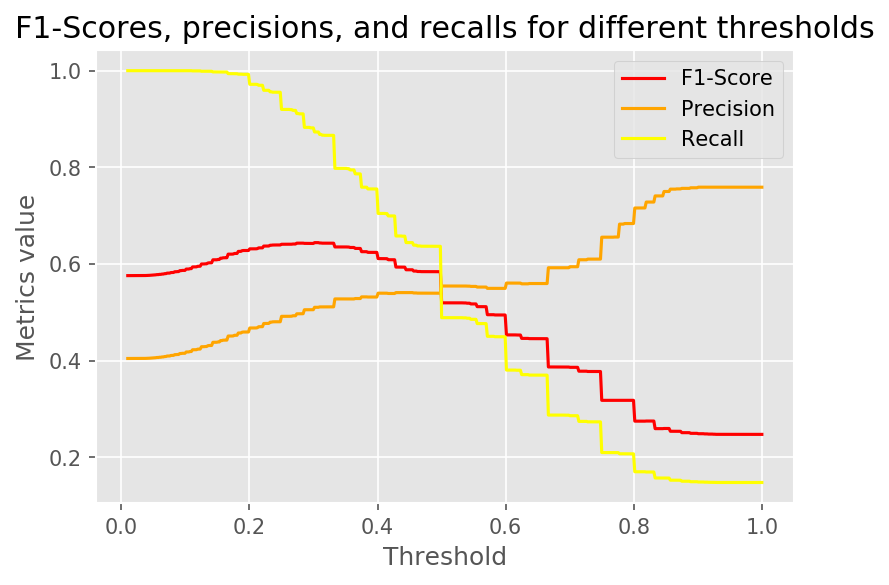

<Figure size 432x288 with 0 Axes>

In [0]:
# Plot F1_scores, precisions, recalls of all thresholds
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(dpi = 150)
plt.plot(threshold_hist, f1_score_hist, label = "F1-Score", color = "red")
plt.plot(threshold_hist, precision_hist, label = "Precision", color = "orange")
plt.plot(threshold_hist, recall_hist, label = "Recall", color = "yellow")
plt.legend(loc = "upper right")
plt.title("F1-Scores, precisions, and recalls for different thresholds")
plt.xlabel("Threshold")
plt.ylabel("Metrics value")
plt.show()
plt.clf()

# BERT + Neural Network

## Input convertion functions



In [0]:
import torch
!pip install -q 'transformers==2.1.1'

# Set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

# Set up BERT tokenizer
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Set up functions for converting input sequence into BERT's input format
def dict2questions(data_dict):
  return data_dict['OrgQuestionText'], data_dict['RelQuestionText']

def questions2seq(q1, q2):
  seq = "[CLS] " + q1 + " [SEP] " + q2 + " [SEP]"
  return seq

def seq2ids(seq, tokenizer):
  tokens = tokenizer.tokenize(seq)
  ids = tokenizer.convert_tokens_to_ids(tokens)
  return ids

def dict2ids(data_dict, tokenizer, length = 512):
  q1, q2 = dict2questions(data_dict)
  seq = questions2seq(q1, q2)
  # Convert tokens to ids
  token_ids = seq2ids(seq, tokenizer)
  if len(token_ids) > length:
    return (0, 0)
  # Add padding to reach the length
  token_ids = token_ids + [0]*(length-len(token_ids))
  # Create segment ids
  segment_ids = [0]*(token_ids.index(102)+1)
  segment_ids = segment_ids + [1]*(length-len(segment_ids))
  return token_ids, segment_ids

def dict2label(data_dict):
  label = data_dict['RelQuestionLabel']
  if type(label) is not int:
    if(label == "Irrelevant"):
      label = 0
    else:
      label = 1
  return label

def data2embeddings(data, bert):
  token_ids, segment_ids, labels = data
  bert_output, _ = bert(input_ids = token_ids, token_type_ids = segment_ids)
  CLS_embeddings = bert_output[:,0,:]
  return CLS_embeddings

     |████████████████████████████████| 317kB 5.0MB/s 
     |████████████████████████████████| 860kB 47.7MB/s 
     |████████████████████████████████| 1.0MB 44.9MB/s 
cuda
Tesla P100-PCIE-16GB


100%|██████████| 231508/231508 [00:00<00:00, 1239155.87B/s]


In [0]:
# Test conversion result
t1, t2 = dict2ids(train_data[0], tokenizer = tokenizer)
print(len(t1), len(t2))
print(t1)
print(t2)
print(dict2label(train_data[0]))

512 512
[101, 2054, 2024, 2070, 1997, 1996, 10198, 1997, 1037, 2149, 9068, 4102, 2000, 1037, 3010, 9068, 1029, 102, 2054, 2024, 2070, 1997, 1996, 10198, 1997, 1037, 2149, 9068, 4102, 2000, 1037, 2413, 9068, 1029, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Batch data loader

In [0]:
# A generator yielding a batch of input data each time
def batch_data_loader(data, batchsize = 16, length = 512):
  # Generator initialization
  token_tensor = []
  segment_tensor = []
  labels = []
  # Iterate through all data
  for data_dict in data:
    # Convert input sequence into BERT's input format
    token_ids, segment_ids = dict2ids(data_dict, tokenizer, length = length)
    # Check if input sequence length exceeds specified limit 
    if type(token_ids) is int:
      continue
    else:
      label = dict2label(data_dict)
      token_tensor.append(token_ids)
      segment_tensor.append(segment_ids)
      labels.append(label)
    # Has generated a batch of input data
    if len(labels) == batchsize:
      token_tensor = torch.tensor(token_tensor).to(device)
      segment_tensor = torch.tensor(segment_tensor).to(device)
      labels = torch.tensor(labels).to(device)
      yield (token_tensor, segment_tensor, labels)
      # Clear list for next batch of data
      token_tensor = []
      segment_tensor = []
      labels = []

In [0]:
# Test dataloader
dataloader = batch_data_loader(train_data, batchsize = 2, length = 128)
token_ids, segment_ids, labels = next(dataloader)
print(token_ids.shape)
print(segment_ids.shape)
print(labels.shape)

torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2])


## Neural network classifier


In [0]:
# Set up classifier
class CLF(torch.nn.Module):
  def __init__(self, input_size, hidden_size):
    super(CLF, self).__init__()
    self.input_size = input_size
    self.linear1 = torch.nn.Linear(self.input_size, hidden_size)
    self.linear2 = torch.nn.Linear(hidden_size, 2)
  
  def forward(self, x):
    out1 = self.linear1(x)
    out2 = self.linear2(torch.tanh(out1))
    return out2

## Training Functions



In [0]:
import numpy as np
from time import time 
from datetime import datetime
import pickle

def forward(classifier, bert, data):
  # Load batch data and compute corresponding CLS embeddings for question pairs
  CLS_embeddings = data2embeddings(data, bert)
  # Forward propagation
  out = classifier(CLS_embeddings)
  return out

def accuracy(y_pred, labels):
  pred = torch.argmax(y_pred, dim=1)
  return torch.sum(pred == labels) / float(len(labels))

def save_checkpoint(config, model, hist):
  lr = config['learning_rate']
  bs = config['batchsize']
  hs = config['hidden_size']
  ln = config['length']
  now = datetime.now()
  t = now.strftime("%m-%d-%H:%M")
  save_name = 'lr:{0:.6f}-bs:{1}-hs:{2}-ln:{3}-t:{4}'.format(lr,bs,hs,ln,t)
  path = '/content/gdrive/My Drive/models/'+save_name+'.pt'
  torch.save(model.state_dict(), path)
  print(F'model saved to {path}')

  with open('/content/gdrive/My Drive/models/'+save_name+'-hist.pkl','wb') as f:
    pickle.dump(hist,f)
    print('history saved')
  return 

def load_checkpoint(path, hidden_size):
  model_path = path + ".pt"
  model = CLF(768, hidden_size)
  model.load_state_dict(torch.load(model_path))
  hist_path = path + "-hist.pkl"
  with open(hist_path, 'rb') as f:
    hist = pickle.load(f)
  print(F'model loaded from {path}')
  return hist, model

def training(config, hist=None, model=None):
  start_time = time()
  # Load config
  num_epochs = config['num_epochs']
  batchsize = config['batchsize']
  length = config['length']
  hidden_size = config['hidden_size']
  learning_rate = config['learning_rate']

  # Training set up
  bert = BertModel.from_pretrained('bert-base-uncased')
  bert.eval()
  bert.cuda()
  if model is None:
    classifier = CLF(768, hidden_size=hidden_size)
    classifier.cuda()
  else:
    classifier = model
    classifier.cuda()
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(classifier.parameters(), lr=learning_rate, weight_decay=1e-3)
  
  # Loss history initialization
  if hist is None:
    hist = {
            'train':
              {
                'batch_loss': [],
                'epoch_loss': [],
                'batch_acc': [],
                'epoch_acc': []
              },
            'valid':
              {
                'batch_loss': [],
                'epoch_loss': [],
                'batch_acc': [],
                'epoch_acc': []
              }
    }

  train_hist = hist['train']
  valid_hist = hist['valid']

  # Train model
  for epoch in range(config['num_epochs']):
    try:
      t0 = time()
      # init
      train_loss = 0.0
      train_acc = 0.0
      num_train_batches = 0
      # Shuffle data and set up dataloader with specific batch size
      np.random.shuffle(train_data)
      train_dataloader = batch_data_loader(train_data, batchsize=batchsize, length=length)

      # Training iterations
      for batch_data in train_dataloader:
        # count the number of batches
        num_train_batches += 1
        # Erase previous gradient
        optimizer.zero_grad()
        # forward
        y_pred = forward(classifier, bert, batch_data)
        # Compute, record, and report loss
        _, _, labels = batch_data
        loss = criterion(y_pred, labels)
        train_hist['batch_loss'].append(loss)
        train_loss += loss
        # calculate accuracy
        acc = accuracy(y_pred, labels)
        train_hist['batch_acc'].append(acc)
        train_acc += acc
        # print
        if num_train_batches % 200 == 1:
          print('batch %d, batch loss: %.4f, batch acc:%.4f, avg loss: %.4f, avg acc: %.4f' \
                %(num_train_batches, loss, acc, train_loss/num_train_batches, train_acc/num_train_batches))
        # Backward propagation
        loss.backward()
        # Update weights
        optimizer.step()
      # record epoch training loss
      train_loss /= num_train_batches
      train_acc /= num_train_batches
      train_hist['epoch_loss'].append(train_loss)
      train_hist['epoch_acc'].append(train_acc)

      # validation after each epoch
      print("doing validation...")
      valid_dataloader = batch_data_loader(valid_data, batchsize=batchsize, length=length)
      with torch.no_grad():
        # init
        num_valid_batches = 0
        valid_loss = 0.0
        valid_acc = 0.0
        for batch_data in valid_dataloader:
          # count the number of batches
          num_valid_batches += 1
          # Forward propagation
          y_pred = forward(classifier, bert, batch_data)
          # Compute, record, and report loss
          _, _, labels = batch_data
          loss = criterion(y_pred, labels)
          valid_hist['batch_loss'].append(loss)
          valid_loss += loss
          # calculate accuracy
          acc = accuracy(y_pred, labels)
          valid_hist['batch_acc'].append(acc)
          valid_acc += acc
          # print
          if num_valid_batches % 200 == 1:
            print('batch %d, batch loss: %.4f, batch acc:%.4f, avg loss: %.4f, avg acc: %.4f' \
                  %(num_valid_batches, loss, acc, valid_loss/num_valid_batches, valid_acc/num_valid_batches))
         
        # record epoch valid loss
        valid_loss /= num_valid_batches
        valid_acc /= num_valid_batches
        valid_hist['epoch_loss'].append(valid_loss)
        valid_hist['epoch_acc'].append(valid_acc)

      epoch_time = time() - t0
      # Report training progress after finishing each epoch
      print("epoch: %d/%d, training loss: %.4f, validation loss: %.4f, time: %.2fs" \
          % (epoch, num_epochs-1, train_loss, valid_loss, epoch_time))

      # save model after each epoch
      save_checkpoint(config, classifier, hist)

    except:
      print('Interrupted! total time: %.2fs' %(time()-start_time))
      save_checkpoint(config, classifier, hist)
      return hist, classifier

  print('Done! total time: %.2fs' %(time()-start_time))
  return hist, classifier

## Training - Hyperparam Random Search

In [0]:
num_random_search = 1
best_config = None
best_classifier = None
best_hist = None
best_valid_loss = None
for i in range(num_random_search):
  # training config
  config = {
        'learning_rate': np.random.uniform(low=1e-5, high=5e-4),
        'num_epochs': 10,
        'batchsize': 100,
        'length': 128,
        'hidden_size': np.random.choice([100]),
  }
  print('Start training...')
  print('Config: ')
  print(config)
  hist, classifier = training(config)
  if i == 0:
    best_config = config 
    best_classifier = classifier
    best_hist = hist
    best_valid_loss = min(hist['valid']['epoch_loss'])
  else:
    current_valid_loss = min(hist['valid']['epoch_loss'])
    if(current_valid_loss < best_valid_loss):
      best_config = config
      best_classifier = classifier
      best_hist = hist
      best_valid_loss = current_valid_loss

100%|██████████| 313/313 [00:00<00:00, 185164.62B/s]

Start training...
Config: 
{'learning_rate': 0.0001493654578788037, 'num_epochs': 10, 'batchsize': 100, 'length': 128, 'hidden_size': 100}



100%|██████████| 440473133/440473133 [00:08<00:00, 52393128.63B/s]


batch 1, batch loss: 0.6620, batch acc:0.7700, avg loss: 0.6620, avg acc: 0.7700
batch 201, batch loss: 0.5529, batch acc:0.6500, avg loss: 0.5653, avg acc: 0.6729
batch 401, batch loss: 0.5009, batch acc:0.7000, avg loss: 0.5361, avg acc: 0.6946
batch 601, batch loss: 0.4543, batch acc:0.7700, avg loss: 0.5225, avg acc: 0.7078
batch 801, batch loss: 0.5044, batch acc:0.7200, avg loss: 0.5121, avg acc: 0.7169
batch 1001, batch loss: 0.5224, batch acc:0.7100, avg loss: 0.5054, avg acc: 0.7225
batch 1201, batch loss: 0.3701, batch acc:0.8300, avg loss: 0.4997, avg acc: 0.7279
batch 1401, batch loss: 0.5017, batch acc:0.7200, avg loss: 0.4956, avg acc: 0.7317
batch 1601, batch loss: 0.5092, batch acc:0.7400, avg loss: 0.4913, avg acc: 0.7354
batch 1801, batch loss: 0.4136, batch acc:0.8100, avg loss: 0.4883, avg acc: 0.7378
batch 2001, batch loss: 0.5174, batch acc:0.7600, avg loss: 0.4858, avg acc: 0.7397
batch 2201, batch loss: 0.4653, batch acc:0.7500, avg loss: 0.4838, avg acc: 0.7414

## Load checkpoint and continue training

Best model link: https://drive.google.com/open?id=1-UAtlUtuYxiwM0UQ2rprDWrnlsksaWu5



In [0]:
# load 
# dir_path = '/content/gdrive/My Drive/models/'
# path = dir_path + 'lr:0.000472-bs:100-hs:200-ln:128-t:12-18-12:41'
# old_hist, old_classifier = load_checkpoint(path, 200) # 200 is hidden size

# If you're not connecting to Ye's google drive,
# comment out above code and run the following code snippet.
model_id = '1-UAtlUtuYxiwM0UQ2rprDWrnlsksaWu5'
downloaded = gdrive.CreateFile({'id': model_id})
path = 'model.pt'
downloaded.GetContentFile(path)
hist_id = '1-UH939wGReC0-GeSD7FyLVgbiz1OGHb3'
downloaded = gdrive.CreateFile({'id': hist_id})
path = 'hist.pkl'
downloaded.GetContentFile(path)
!ls '/content/'

old_classifier = CLF(768, 200)
old_classifier.load_state_dict(torch.load('/content/model.pt'))
with open('/content/hist.pkl', 'rb') as f:
  old_hist = pickle.load(f)

print(old_hist['valid']['epoch_loss'])
print(old_classifier)
print('current model has been trained %d epochs.' %(len(old_hist['valid']['epoch_loss'])))

adc.json  hist.pkl  sample_data    train_data.pkl
gdrive	  model.pt  test_data.pkl  valid_data.pkl
[tensor(0.4480, device='cuda:0'), tensor(0.4294, device='cuda:0'), tensor(0.4298, device='cuda:0'), tensor(0.4035, device='cuda:0'), tensor(0.4027, device='cuda:0'), tensor(0.3877, device='cuda:0'), tensor(0.3838, device='cuda:0'), tensor(0.3875, device='cuda:0'), tensor(0.3820, device='cuda:0'), tensor(0.3770, device='cuda:0'), tensor(0.3819, device='cuda:0'), tensor(0.3695, device='cuda:0'), tensor(0.3673, device='cuda:0'), tensor(0.3729, device='cuda:0'), tensor(0.3682, device='cuda:0'), tensor(0.3617, device='cuda:0'), tensor(0.3661, device='cuda:0'), tensor(0.3670, device='cuda:0'), tensor(0.3778, device='cuda:0'), tensor(0.3723, device='cuda:0'), tensor(0.3701, device='cuda:0'), tensor(0.3568, device='cuda:0'), tensor(0.3628, device='cuda:0'), tensor(0.3602, device='cuda:0'), tensor(0.3560, device='cuda:0'), tensor(0.3562, device='cuda:0'), tensor(0.3697, device='cuda:0'), tensor(0.

In [0]:
# continue training 
config = {'learning_rate': 0.000472, 'num_epochs': 0, 'batchsize': 100, 'length': 128, 'hidden_size': 200}
hist, classifier = training(config, hist=old_hist, model=old_classifier)

Done! total time: 3.05s


## plots

current model has been trained 30 epochs.


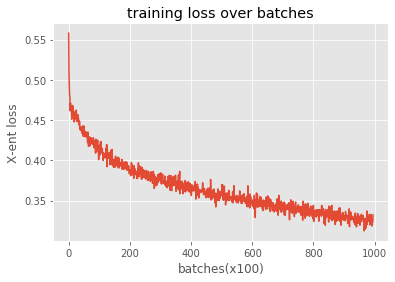

In [0]:
# print(best_config)
# print(best_valid_loss)
n_epochs = len(hist['valid']['epoch_loss'])
print('current model has been trained %d epochs.' %(n_epochs))
import matplotlib.pyplot as plt
loss_hist = [t.tolist() for t in hist['train']['batch_loss']]
avg = []
for i in range(len(loss_hist) // 100 + 1):
  avg.append(np.mean(loss_hist[i*100:(i+1)*100]))
# plt.plot(np.arange(len(hist['train']['batch_loss'])), hist['train']['batch_loss'])
plt.plot(np.arange(len(avg)), avg)
plt.title('training loss over batches')
plt.xlabel('batches(x100)')
plt.ylabel('X-ent loss')
plt.show()

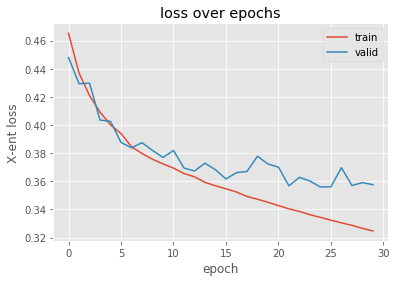

In [0]:
train_epoch_loss = hist['train']['epoch_loss']
valid_epoch_loss = hist['valid']['epoch_loss']
plt.plot(np.arange(n_epochs), train_epoch_loss, label='train')
plt.plot(np.arange(n_epochs), valid_epoch_loss, label='valid')
plt.title('loss over epochs')
plt.xlabel('epoch')
plt.ylabel('X-ent loss')
plt.legend()
plt.show()

## Evaluation

In [0]:
from functools import reduce 

def precision(y_pred, labels):
  true_pos = torch.sum((y_pred+labels) == 2).float()
  false_pos = torch.sum((y_pred-labels) == 1)
  p = true_pos / (true_pos + false_pos)
  return p

def recall(y_pred, labels):
  true_pos = torch.sum((y_pred+labels) == 2).float()
  false_neg = torch.sum((labels-y_pred) == 1)
  r = true_pos / (true_pos + false_neg)
  return r 

def f1_score(p, r):
  f1 = 2*p*r / (p+r)
  return f1 

def accuracy(y_pred, labels):
  true = torch.sum(y_pred == labels).float()
  return true / len(labels)

def evaluate(classifier, data, batchsize=100, length=128):
  bert = BertModel.from_pretrained('bert-base-uncased')
  bert.eval()
  bert.cuda()
  data_loader = batch_data_loader(data, batchsize=batchsize, length=length)
  labels = []
  y_pred = []
  with torch.no_grad():
    for batch_data in data_loader:
      # append labels
      labels.append(batch_data[-1])
      # prediction
      out = forward(classifier, bert, batch_data)
      prediction = torch.argmax(out, dim=1)
      # append prediction
      y_pred.append(prediction)
  # concatnate
  labels = torch.cat(labels)
  y_pred = torch.cat(y_pred)
  print(y_pred[:500])
  print(labels[:500])
  a = accuracy(y_pred, labels)
  p = precision(y_pred, labels)
  r = recall(y_pred, labels)
  f1 = f1_score(p, r)
  result = {'precision': p, 'recall': r, 'f1_score': f1, 'accuracy': a}
  return result

In [0]:
result = evaluate(classifier, test_data)
print(result)

tensor([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,

## Case study

In [0]:
# first 200 labels of test set
a = np.array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0])
# first 200 prediction of bert+nn model
b = np.array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0])
# first 200 prediction of baseline
c = np.array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
              1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
              0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
              1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
              0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
              1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
              0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
              1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
              1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0])

samples = test_data[:200]
nn_false_pos = samples[(b-a == 1)]
nn_false_neg = samples[(a-b == 1)]
base_false_pos = samples[(c-a == 1)]
base_false_neg = samples[(a-c == 1)]

nn_good_base_bad = samples[np.logical_and((a == b),(c != a))]
print('Cases where bert predicts correctly while baseline fails to\n')
for i in nn_good_base_bad[:20]:
  label = 'Duplicated' if i['RelQuestionLabel'] else 'Not Duplicated'
  print('label: ', label)
  print('Q1: ', i['OrgQuestionText'])
  print('Q2: ', i['RelQuestionText'])
  print()

nn_bad_base_good = samples[np.logical_and((a == c),(b != a))]
print('Cases where baseline predicts correctly while bert fails to\n')
for i in nn_bad_base_good[:10]:
  label = 'Duplicated' if i['RelQuestionLabel'] else 'Not Duplicated'
  print('label: ', label)
  print('Q1: ', i['OrgQuestionText'])
  print('Q2: ', i['RelQuestionText'])
  print()

both_bad = samples[np.logical_and((a != c), (a != b))]
print('Cases where both models fail\n')
for i in both_bad[:10]:
  label = 'Duplicated' if i['RelQuestionLabel'] else 'Not Duplicated'
  print('label: ', label)
  print('Q1: ', i['OrgQuestionText'])
  print('Q2: ', i['RelQuestionText'])
  print()

print('# of bert good:',len(nn_good_base_bad))
print('# of bert bad:', len(nn_bad_base_good))
print('# of both bad:', len(both_bad))
print('# of bert false pos', len(nn_false_pos))
print('# of bert false neg', len(nn_false_neg))
print('# of base false pos', len(base_false_pos))
print('# of base false neg', len(base_false_neg))

# print('# of false positive:', len(false_pos))
# print('# of false negative:', len(false_neg))
# print("False positive cases:")
# for i in false_pos:
#   print('Q1: ', i['OrgQuestionText'])
#   print('Q2: ', i['RelQuestionText'])
#   print()
# print("False negative cases:")
# for i in false_neg:
#   print('Q1: ', i['OrgQuestionText'])
#   print('Q2: ', i['RelQuestionText'])
#   print()

Cases where bert predicts correctly while baseline fails to

label:  Not Duplicated
Q1:  What is the corporate culture like at Citizens Financial? How is the culture different than other companies?
Q2:  What is the corporate culture like at Lakeland Financial? How is the culture different than other companies?

label:  Not Duplicated
Q1:  What is the difference between an observation and a criticism?
Q2:  What is the difference between an idea and an observation?

label:  Not Duplicated
Q1:  Who is best actors?
Q2:  Who is the best actor in kollywood?

label:  Not Duplicated
Q1:  Is it possible for human to survive if they travel at the speed of light?
Q2:  What happens if you travel faster than the speed of light?

label:  Not Duplicated
Q1:  Where are the good co-working spaces located in Bangalore?
Q2:  Are there any good coworking spaces in Bangalore for night work?

label:  Not Duplicated
Q1:  What's the best investment I can make with ₹500000?
Q2:  What is the best investment you

## Test ground

In [0]:
!pip freeze

absl-py==0.8.1
alabaster==0.7.12
albumentations==0.1.12
altair==4.0.0
asgiref==3.2.3
astor==0.8.1
astropy==3.0.5
atari-py==0.2.6
atomicwrites==1.3.0
attrs==19.3.0
audioread==2.1.8
autograd==1.3
Babel==2.7.0
backcall==0.1.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.6.3
bleach==3.1.0
blis==0.2.4
bokeh==1.0.4
boto==2.49.0
boto3==1.10.40
botocore==1.13.40
Bottleneck==1.3.1
branca==0.3.1
bs4==0.0.1
bz2file==0.98
cachetools==4.0.0
certifi==2019.11.28
cffi==1.13.2
chainer==6.5.0
chardet==3.0.4
chart-studio==1.0.0
Click==7.0
cloudpickle==1.2.2
cmake==3.12.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.0
cupy-cuda101==6.5.0
cvxopt==1.2.3
cvxpy==1.0.25
cycler==0.10.0
cymem==2.0.3
Cython==0.29.14
daft==0.0.4
dask==1.1.5
dataclasses==0.7
datascience==0.10.6
decorator==4.4.1
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.1.1
distributed==1.25.3
Django==3.0
dlib==19.18.0
dm-sonnet==1.3

In [0]:
import torch
from torch import nn
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

model = Model()
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
torch.save(model.state_dict(), path)
print(F'model save to {model_save_name}')

In [0]:
from datetime import datetime
now = datetime.now()
learning_rate = 0.0005
current_time = now.strftime("%m/%d/%y-%H:%M:%S")
model_save_name = F'lr={learning_rate}--{current_time}'
path = F"/content/gdrive/My Drive/models/{model_save_name}" 
print(F'model save to {path}')

### compare different hidden size


In [0]:
model1 = 'lr:0.000149-bs:100-hs:100-ln:128-t:12-19-20:36'
model2 = 'lr:0.000472-bs:100-hs:200-ln:128-t:12-17-11:09'
path1 =  F"/content/gdrive/My Drive/models/{model1}"
path2 =  F"/content/gdrive/My Drive/models/{model2}"
hist1, clf1 = load_checkpoint(path1, 100)
hist2, clf2 = load_checkpoint(path2, 200)

model loaded from /content/gdrive/My Drive/models/lr:0.000149-bs:100-hs:100-ln:128-t:12-19-20:36
model loaded from /content/gdrive/My Drive/models/lr:0.000472-bs:100-hs:200-ln:128-t:12-17-11:09


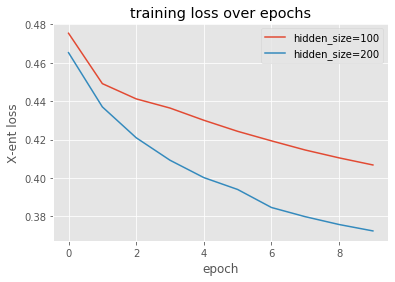

In [0]:
train_epoch_loss1 = hist1['train']['epoch_loss']
train_epoch_loss2 = hist2['train']['epoch_loss']
n_epochs = len(train_epoch_loss1)
plt.plot(np.arange(n_epochs), train_epoch_loss1, label='hidden_size=100')
plt.plot(np.arange(n_epochs), train_epoch_loss2, label='hidden_size=200')
plt.title('training loss over epochs')
plt.xlabel('epoch')
plt.ylabel('X-ent loss')
plt.legend()
plt.show()

### Evaluate overfitting

In [0]:
epoch_model = {
    '15': 'lr:0.000472-bs:100-hs:200-ln:128-t:12-17-17:07',
    '20': 'lr:0.000472-bs:100-hs:200-ln:128-t:12-17-22:46',
    '25': 'lr:0.000472-bs:100-hs:200-ln:128-t:12-18-07:05',
    '30': 'lr:0.000472-bs:100-hs:200-ln:128-t:12-18-12:41'
}

eval_result = {}
for n, name in epoch_model.items():
  _, model = load_checkpoint(F'/content/gdrive/My Drive/models/{name}', 200)
  model.cuda()
  eval_result[n] = evaluate(model, test_data)

for n, result in eval_result.items():
  print(n)
  print(result)

model loaded from /content/gdrive/My Drive/models/lr:0.000472-bs:100-hs:200-ln:128-t:12-17-17:07
tensor([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 